# Text Analytics - MsC Data Science (part time) 24' | 4th Assignement | Exercise 1


# **Exercise 1 | Sentiment Classifier** | RNN

In [ ]:
!pip install -U nltk
!pip install datasets
#!pip install --upgrade tensorflow
!pip install spacy
!pip install tqdm
!pip install -U gensim
!pip install torch torchvision
!pip install -U keras-tuner
!pip install  tensorflow==2.15.0
!pip install -U fasttext
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Import and split the dataset into training and test subsets

* The dataset has 20000 words
* 70% Training - 15% Test - 15%

In [ ]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Load the dataset
dataset = load_dataset("dair-ai/emotion")

# Extract text and labels for train and test sets
X_train = dataset["train"]["text"]
y_train = dataset["train"]["label"]
X_val = dataset["validation"]["text"]
y_val = dataset["validation"]["label"]
X_test = dataset["test"]["text"]
y_test = dataset["test"]["label"]


# Confirm the sizes of train and validation sets
print("Train set size: {}".format(len(X_train)))
print("Validation set size: {}".format(len(X_val)))
print("Validation set size: {}".format(len(X_test)))


/home/gtriant/.local/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Train set size: 16000
Validation set size: 2000
Validation set size: 2000


In [ ]:
# Map integer labels to their corresponding string names
label_mapping = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise",
    # Add more mappings as needed
}

# Extract distinct labels from the training set
distinct_train_labels = set(y_train)

# Print distinct train label names with their string representations
label_names = []
print("Distinct train label names:")
for label in distinct_train_labels:
    label_name = label_mapping.get(label, "Unknown")
    label_names.append(label_name)
    print(f"Label {label}: {label_name}")


Distinct train label names:
Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise


## Tokenize the dataset

* Split into sentences
* Tokenize into words

In [ ]:
import spacy.cli
import spacy
spacy.cli.download("en_core_web_sm")
from tqdm import tqdm

# Load English language model in spaCy and disable unnecessary components
nlp = spacy.load('en_core_web_sm', disable=["tagger", "parser", "ner"])
nlp.add_pipe('sentencizer')  # Add a pipeline component for sentence segmentation

def tokenize_samples(samples):
    tokenized_samples = []
    for i in tqdm(range(len(samples))):
        doc = nlp(samples[i])  # Tokenize the sample into sentences
        tokens = []
        for sent in doc.sents:
            for tok in sent:  # Iterate through the words of the sentence
                if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text:
                    continue
                if tok.text.strip():
                    tokens.append(tok.text.replace('"', "'").strip())
        tokenized_samples.append(tokens)
    return tokenized_samples

# Tokenize the training, validation and test samples
X_train_tokenized = tokenize_samples(X_train)
X_val_tokenized = tokenize_samples(X_val)
X_test_tokenized = tokenize_samples(X_test)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 5.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


  0%|                                                 | 0/16000 [00:00<?, ?it/s]/home/gtriant/.local/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████████████████████████████████| 2000/2000 [00:03<00:00, 528.90it/s]


In [ ]:
for item in X_train_tokenized[:5]:
  print(item)
  print()

['i', 'did', 'nt', 'feel', 'humiliated']

['i', 'can', 'go', 'from', 'feeling', 'so', 'hopeless', 'to', 'so', 'damned', 'hopeful', 'just', 'from', 'being', 'around', 'someone', 'who', 'cares', 'and', 'is', 'awake']

['i', 'm', 'grabbing', 'a', 'minute', 'to', 'post', 'i', 'feel', 'greedy', 'wrong']

['i', 'am', 'ever', 'feeling', 'nostalgic', 'about', 'the', 'fireplace', 'i', 'will', 'know', 'that', 'it', 'is', 'still', 'on', 'the', 'property']

['i', 'am', 'feeling', 'grouchy']



## One hot vectors for the different labels

In [ ]:
import tensorflow as tf

# Convert with Keras
y_train_1_hot = tf.keras.utils.to_categorical(y_train,
                                              num_classes=len(distinct_train_labels ))
y_val_1_hot = tf.keras.utils.to_categorical(y_val,
                                            num_classes=len(distinct_train_labels ))
y_test_1_hot = tf.keras.utils.to_categorical(y_test,
                                            num_classes=len(distinct_train_labels ))

for lidx,label in enumerate(distinct_train_labels ):
  print("Index: {} Category: {}".format(lidx,label))
print("Label index: {} | 1-hot vector:  {}".format(y_train[0],
                                                   y_train_1_hot[0]))
print("Label index: {} | 1-hot vector:  {}".format(y_train[10],
                                                   y_train_1_hot[10]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[20],
                                                   y_train_1_hot[20]))

print("Label index: {} | 1-hot vector:  {}".format(y_train[400],
                                                   y_train_1_hot[400]))


2024-05-30 22:03:57.407614: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 22:03:57.432061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 22:03:57.432084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 22:03:57.432778: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 22:03:57.437377: I tensorflow/core/platform/cpu_feature_guar

Index: 0 Category: 0
Index: 1 Category: 1
Index: 2 Category: 2
Index: 3 Category: 3
Index: 4 Category: 4
Index: 5 Category: 5
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 0 | 1-hot vector:  [1. 0. 0. 0. 0. 0.]
Label index: 3 | 1-hot vector:  [0. 0. 0. 1. 0. 0.]
Label index: 1 | 1-hot vector:  [0. 1. 0. 0. 0. 0.]


## TF-IDF

* MLP classifiers expect **numerical input data**, so we'll need to convert our tokenized samples into a numerical format before feeding them into the MLP
* Convert list of tokens to strings (sentences) because that is the format that TfidVectorizer() expects
* Initialize a TfidfVectorizer(),
* Fit it on the training data to learn the vocabulary and IDF weights, and
* transform both the training and validation data into TF-IDF feature matrices.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert tokenized lists to strings
X_train_str = [' '.join(tokens) for tokens in X_train_tokenized]
X_val_str = [' '.join(tokens) for tokens in X_val_tokenized]
X_test_str = [' '.join(tokens) for tokens in X_test_tokenized]

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform on training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_str)

# Transform validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val_str)

# Transform validation data
X_test_tfidf = tfidf_vectorizer.transform(X_test_str)

In [ ]:
# Reduce dimensionality using svd 5000 --> 500
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=500, random_state=4321)
X_train_svd = svd.fit_transform(X_train_tfidf)
X_val_svd = svd.transform(X_val_tfidf)
X_test_svd = svd.transform(X_test_tfidf)

## **MLP text classifier with TF-IDF Features as baseline**

#### Custom functions

* **Metrics Callback Class:** Define a custom callback to calculate and log metrics after each epoch.
    * **__init__ Method:** Initialize with validation data.
    * **on_epoch_end Method:** Execute at the end of each epoch to calculate metrics.
* **Getting Model Predictions:** Predict validation data and convert probabilities to class labels.
* **Convert Targets to Appropriate Format:** Ensure true labels are in the correct format for metric calculations.
* **Calculate Metrics:**
    * **Precision, Recall, F1 Score:** Compute these metrics with zero division handling.
    * **AUC:** Compute the AUC score for multi-class classification.
* **Log and Print Metrics:** Store metrics in the logs dictionary and print them for monitoring.

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score
import numpy as np

class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, train_data, valid_data):
        super(Metrics, self).__init__()
        self.train_data = train_data
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Validation metrics
        val_predict_probs = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(val_predict_probs, -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ, dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
            val_targ = np.argmax(val_targ, -1)

        _val_f1 = f1_score(val_targ, val_predict, average="weighted", zero_division=0)
        _val_recall = recall_score(val_targ, val_predict, average="weighted", zero_division=0)
        _val_precision = precision_score(val_targ, val_predict, average="weighted", zero_division=0)

        if len(val_targ.shape) == 1:
            val_targ = tf.one_hot(val_targ, depth=val_predict_probs.shape[1])
        _val_auc = roc_auc_score(val_targ, val_predict_probs, average="weighted", multi_class='ovr')

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        logs['val_auc'] = _val_auc

        # Training metrics
        train_predict_probs = self.model.predict(self.train_data[0])
        train_predict = np.argmax(train_predict_probs, -1)
        train_targ = self.train_data[1]
        train_targ = tf.cast(train_targ, dtype=tf.float32)
        if len(train_targ.shape) == 2 and train_targ.shape[1] != 1:
            train_targ = np.argmax(train_targ, -1)

        _train_f1 = f1_score(train_targ, train_predict, average="weighted", zero_division=0)
        _train_recall = recall_score(train_targ, train_predict, average="weighted", zero_division=0)
        _train_precision = precision_score(train_targ, train_predict, average="weighted", zero_division=0)

        if len(train_targ.shape) == 1:
            train_targ = tf.one_hot(train_targ, depth=train_predict_probs.shape[1])
        _train_auc = roc_auc_score(train_targ, train_predict_probs, average="weighted", multi_class='ovr')

        logs['train_f1'] = _train_f1
        logs['train_recall'] = _train_recall
        logs['train_precision'] = _train_precision
        logs['train_auc'] = _train_auc

        print(f" — train_f1: {_train_f1:.6f} — train_precision: {_train_precision:.6f} — train_recall: {_train_recall:.6f} — train_auc: {_train_auc:.6f}")
        print(f" — val_f1: {_val_f1:.6f} — val_precision: {_val_precision:.6f} — val_recall: {_val_recall:.6f} — val_auc: {_val_auc:.6f}")
        return



#### Basic MLP MODEL

* **Sequential Model:** A linear stack of layers.
* **First Dense Layer:** 512 neurons, ReLU activation, input dimension is the number of features in X_train_svd.
* **Dropout Layer:** 30% dropout rate to prevent overfitting.
* **Second Dense Layer:** 256 neurons, ReLU activation.
* **Dropout Layer:** 50% dropout rate to prevent overfitting.
* **Output Dense Layer:** Number of neurons equal to the number of distinct labels, softmax activation for multi-class classification.

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy

# Define and compile the model
model = Sequential()
model.add(Dense(512, input_dim=X_train_svd.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(distinct_train_labels), activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               256512    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 389382 (1.49 MB)
Trainable params: 389382 (1.49 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


* **Compile Model:**
    * **Loss Function:** Categorical cross-entropy for multi-class classification.
    * **Optimizer:** Adam optimizer with a learning rate of 0.001.
    * **Metrics:** Categorical accuracy to measure the performance of the model.
* **Create Directory:** Check if the checkpoints directory exists; if not, create it. This is where the model checkpoints will be saved.
* **ModelCheckpoint Callback:**
    * **Monitor:** Monitors the 'val_f1' score.
    * **Mode:** 'max', meaning it will save the model with the highest 'val_f1' score.
    * **Verbose:** Set to 2 to provide detailed logging.
    * **Save only the best model and the best weights** (with the highest 'val_f1' score).

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=[CategoricalAccuracy()])

# Ensure checkpoints directory exists
if not os.path.exists('./checkpoints'):
    os.makedirs('./checkpoints')

# Define the checkpoint callback
checkpoint = ModelCheckpoint('checkpoints/tfidf_mlp.weights.h5',
                             monitor='val_f1',
                             mode='max', verbose=2,
                             save_best_only=True,
                             save_weights_only=True)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # or 'val_categorical_accuracy' based on your needs
                               patience=5,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)

* **Training Data:** X_train_svd and y_train_1_hot are used for training.
* **Validation Data:** X_val_svd and y_val_1_hot are used for validation.
* **Batch Size:** 256 samples per batch.
* **Epochs:** Train for 50 epochs.
* **Shuffle:** Shuffle the training data at the beginning of each epoch.
* **Callbacks:**
    * **Metrics:** Custom callback to calculate and log metrics (F1, precision, recall, AUC) at the end of each epoch.
    * **Checkpoint:** Saves the best model based on the validation F1 score.
    * **EarlyStopping:** Monitors the validation loss and stops training if it does not improve over 5 epochs. It will restore the model weights from the epoch with the best validation loss.

In [ ]:
history = model.fit(X_train_svd, y_train_1_hot,
                    validation_data=(X_val_svd, y_val_1_hot),
                    batch_size=150,
                    epochs=50,
                    shuffle=True,
                    callbacks=[Metrics(train_data=(X_train_svd, y_train_1_hot), valid_data=(X_val_svd, y_val_1_hot)), checkpoint, early_stopping])

Epoch 1/50
500/500 [==============================] - 1s 2ms/step
 — train_f1: 0.650191 — train_precision: 0.721439 — train_recall: 0.700438 — train_auc: 0.939080
 — val_f1: 0.621794 — val_precision: 0.704101 — val_recall: 0.678000 — val_auc: 0.921337

Epoch 1: val_f1 improved from -inf to 0.62179, saving model to checkpoints/tfidf_mlp.weights.h5
107/107 [==============================] - 3s 19ms/step - loss: 1.3798 - categorical_accuracy: 0.4711 - val_loss: 0.9587 - val_categorical_accuracy: 0.6780 - val_f1: 0.6218 - val_recall: 0.6780 - val_precision: 0.7041 - val_auc: 0.9213 - train_f1: 0.6502 - train_recall: 0.7004 - train_precision: 0.7214 - train_auc: 0.9391
Epoch 2/50
500/500 [==============================] - 1s 2ms/step
 — train_f1: 0.805320 — train_precision: 0.821586 — train_recall: 0.816125 — train_auc: 0.969207
 — val_f1: 0.761098 — val_precision: 0.782978 — val_recall: 0.774000 — val_auc: 0.949014

Epoch 2: val_f1 improved from 0.62179 to 0.76110, saving model to checkpoi

## **Visualize Model's Training History**

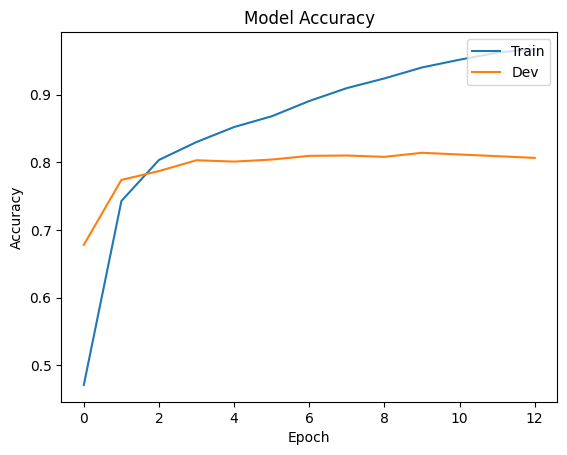

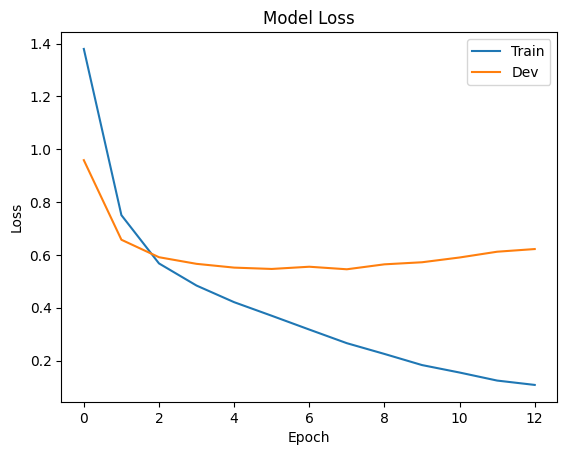

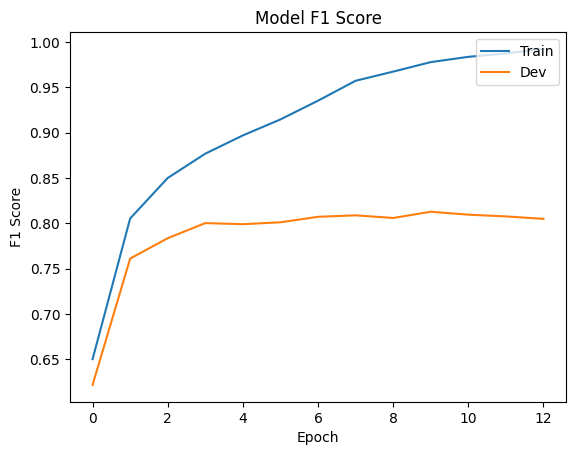

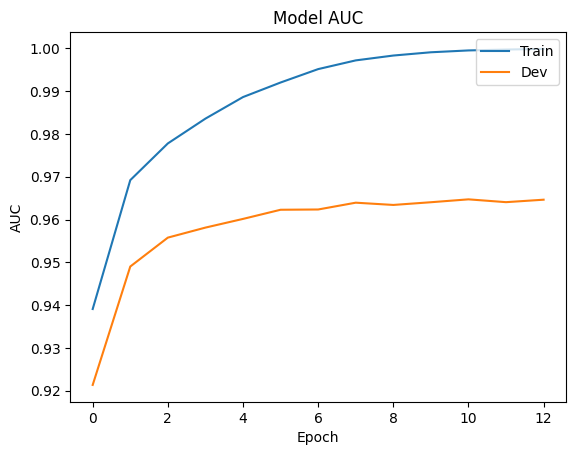

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for F1 score
plt.plot(history.history['train_f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for AUC
plt.plot(history.history['train_auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

## **Evaluate the MLP's model performance**

63/63 [==============================] - 0s 2ms/step
Classification Report for validation data:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       550
           1       0.83      0.87      0.85       704
           2       0.75      0.69      0.72       178
           3       0.84      0.78      0.81       275
           4       0.72      0.77      0.74       212
           5       0.76      0.58      0.66        81

    accuracy                           0.81      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.81      0.81      0.81      2000



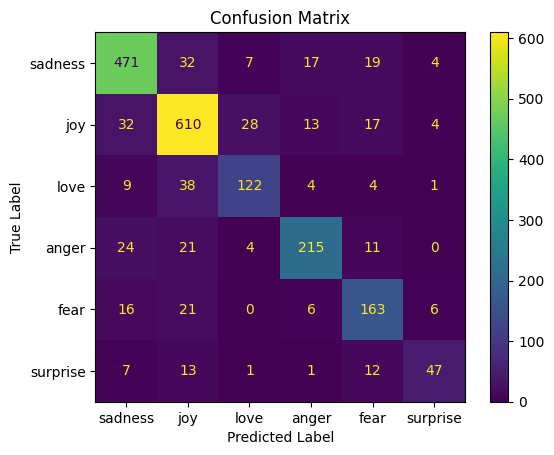

In [ ]:
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


distinct_train_labels_list=list(distinct_train_labels)
distinct_train_labels_string=[str(x) for x in distinct_train_labels_list]

# Load the saved weights into the model
model.load_weights('checkpoints/tfidf_mlp.weights.h5')


# Generate predictions on the validation set
predictions = np.argmax(model.predict(X_val_svd), -1)

# Convert numerical labels to their corresponding class names
predictions_classes = [distinct_train_labels_string[pred] for pred in predictions]
y_val_classes = [distinct_train_labels_string[label] for label in y_val]

# Print classification report for validation set
print("Classification Report for validation data:")
print(classification_report(y_val_classes, predictions_classes))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, predictions)

# Plotting the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp.plot(values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# **RNN model** (Bidirectional GRU & BiLSTM + Linear self-attention)

## Convert text (sequence of words) to sequence of indexes and PAD the sequences
Max sequency length is set to 20 as the average word count in a twitter message is 19

In [ ]:
import numpy as np
# Get mean and std of sequence length on trainning set
print(np.mean([len(x) for x in X_train_tokenized]))
print(np.std([len(x) for x in X_train_tokenized]))

19.5019375
11.122623172889288


### Calculate the mean length and standard deviation of tweets message in the dataset

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30
EMBEDDING_DIM = 300

vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', ngrams=1,
              output_sequence_length=MAX_SEQUENCE_LENGTH)

vectorizer.adapt([" ".join(x) for x in X_train_tokenized])

In [ ]:
for widx, word in zip(vectorizer(' '.join(X_train_tokenized[14])).numpy().tolist(),X_train_tokenized[14]):
  print((widx,word))

(2, 'i')
(20, 'have')
(4761, 'immense')
(1679, 'sympathy')
(25, 'with')
(6, 'the')
(989, 'general')
(261, 'point')
(21, 'but')
(30, 'as')
(7, 'a')
(877, 'possible')
(9704, 'proto')
(1593, 'writer')
(191, 'trying')
(5, 'to')
(162, 'find')
(54, 'time')
(5, 'to')
(226, 'write')
(12, 'in')
(6, 'the')
(3380, 'corners')
(10, 'of')
(82, 'life')
(4, 'and')
(25, 'with')
(97, 'no')
(1772, 'sign')
(10, 'of')


## Initialize embedding matrix with fasttext pre-trained embedings

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# Force overwrite if the file already exists
!gzip -df cc.en.300.bin.gz

--2024-05-30 22:04:31--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.85.158.125, 52.85.158.78, 52.85.158.127, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.85.158.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4503593528 (4,2G) [application/octet-stream]
Saving to: ‘cc.en.300.bin.gz’

cc.en.300.bin.gz    100%[===================>]   4,19G  9,20MB/s    in 9m 12s  

2024-05-30 22:13:44 (7,78 MB/s) - ‘cc.en.300.bin.gz’ saved [4503593528/4503593528]



In [ ]:
import numpy as np
import fasttext

fasttext_model = fasttext.load_model('cc.en.300.bin')
embedding_matrix = np.zeros(shape=(MAX_WORDS, 300))

for w2idx, _word in enumerate(vectorizer.get_vocabulary()):
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    embedding_matrix[w2idx] = fasttext_model.get_word_vector(_word)

del fasttext_model

## **Bidirectional GRU**
This code defines and trains a neural network model using TensorFlow for text classification. The model uses a combination of embedding layers, bidirectional GRU layers, and dense layers, with dropout applied to prevent overfitting. Additionally, the code includes custom metrics for F1-score, precision, and recall, and implements early stopping to halt training when the validation performance stops improving.

- This custom callback computes F1-score, recall, and precision at the end of each epoch on the validation data.
- Predictions are made on the validation data, and the true labels are compared to compute the metrics.

In [ ]:
import tensorflow as tf
from sklearn.metrics import f1_score, recall_score, precision_score
import numpy as np
import os


class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), -1)
        val_targ = self.validation_data[1]
        val_targ = tf.cast(val_targ,dtype=tf.float32)
        if len(val_targ.shape) == 2 and val_targ.shape[1] != 1:
          val_targ = np.argmax(val_targ, -1)


        _val_f1 = f1_score(val_targ, val_predict,average="weighted")
        _val_recall = recall_score(val_targ, val_predict,average="weighted")
        _val_precision = precision_score(val_targ, val_predict,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

- A sequential model is defined.
- An embedding layer is used to convert words to dense vectors.
- A bidirectional GRU layer processes the sequence data.
- Dense layers with dropout are used for classification.
- The model is compiled with the Adam optimizer and categorical cross-entropy loss.

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, GRU, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

GRU_SIZE = 300
DENSE = 300


# create empty sequential model
model = tf.keras.Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorizer)
# add an embedding layer
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))

# Use 0.33 dropout probabillity
model.add(Dropout(0.33))
# add a bidirectional gru layer with 0.33 variational (recurrent) dropout
model.add(Bidirectional(GRU(GRU_SIZE, return_sequences=False, recurrent_dropout = 0.33)))
model.add(Dropout(0.33))

# Add GlobalAveragePooling1D to reduce the sequence dimension
#model.add(GlobalAveragePooling1D())

# add an MLP with 1 hidden layer
model.add(Dense(units=DENSE, activation='relu' ))
model.add(Dropout(0.33))
model.add(Dense(len(distinct_train_labels), activation='softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=["categorical_accuracy"])

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)

history = model.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=256,
              epochs=40,
              shuffle=True,
              callbacks=[Metrics(valid_data=(val_data, y_val_1_hot)),early_stopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 30, 300)           30000000  
                                                                 
 dropout_2 (Dropout)         (None, 30, 300)           0         
                                                                 
 bidirectional (Bidirection  (None, 600)               1083600   
 al)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 600)               0         
                                                                 
 dense_3 (Dense)             (None, 300)              

/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 2s 28ms/step
 — val_f1: 0.403883 — val_precision: 0.428572 — val_recall: 0.495000
63/63 [==============================] - 28s 446ms/step - loss: 1.4020 - categorical_accuracy: 0.4739 - val_loss: 1.3140 - val_categorical_accuracy: 0.4950 - val_f1: 0.4039 - val_recall: 0.4950 - val_precision: 0.4286
Epoch 3/40


/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 2s 27ms/step
 — val_f1: 0.529126 — val_precision: 0.546465 — val_recall: 0.586500
63/63 [==============================] - 28s 447ms/step - loss: 1.2871 - categorical_accuracy: 0.5176 - val_loss: 1.1741 - val_categorical_accuracy: 0.5865 - val_f1: 0.5291 - val_recall: 0.5865 - val_precision: 0.5465
Epoch 4/40


/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 2s 30ms/step
 — val_f1: 0.638547 — val_precision: 0.643269 — val_recall: 0.677000
63/63 [==============================] - 28s 452ms/step - loss: 1.1475 - categorical_accuracy: 0.5805 - val_loss: 0.9289 - val_categorical_accuracy: 0.6770 - val_f1: 0.6385 - val_recall: 0.6770 - val_precision: 0.6433
Epoch 5/40


/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 2s 29ms/step
 — val_f1: 0.703111 — val_precision: 0.733755 — val_recall: 0.724500
63/63 [==============================] - 28s 445ms/step - loss: 0.9658 - categorical_accuracy: 0.6552 - val_loss: 0.7787 - val_categorical_accuracy: 0.7245 - val_f1: 0.7031 - val_recall: 0.7245 - val_precision: 0.7338
Epoch 6/40
63/63 [==============================] - 2s 29ms/step
 — val_f1: 0.753556 — val_precision: 0.769346 — val_recall: 0.765000
63/63 [==============================] - 29s 455ms/step - loss: 0.8144 - categorical_accuracy: 0.7072 - val_loss: 0.6542 - val_categorical_accuracy: 0.7650 - val_f1: 0.7536 - val_recall: 0.7650 - val_precision: 0.7693
Epoch 7/40
63/63 [==============================] - 2s 29ms/step
 — val_f1: 0.773587 — val_precision: 0.790872 — val_recall: 0.783500
63/63 [==============================] - 29s 459ms/step - loss: 0.7077 - categorical_accuracy: 0.7487 - val_loss: 0.5735 - val_categorical_accuracy: 0.7835 - val_f1: 0.7736 

KeyboardInterrupt: 

## **Visualize BiDirectional GRU Model's Training History**

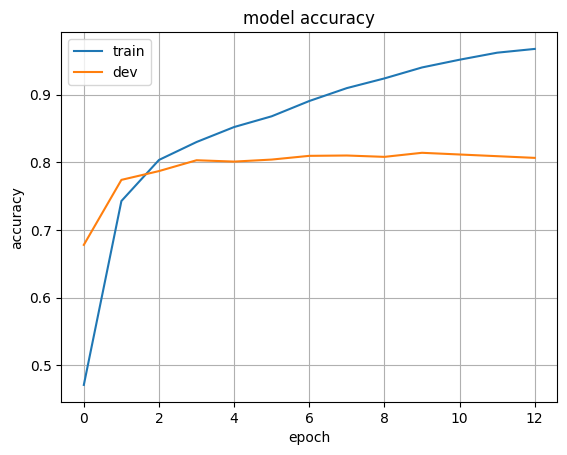

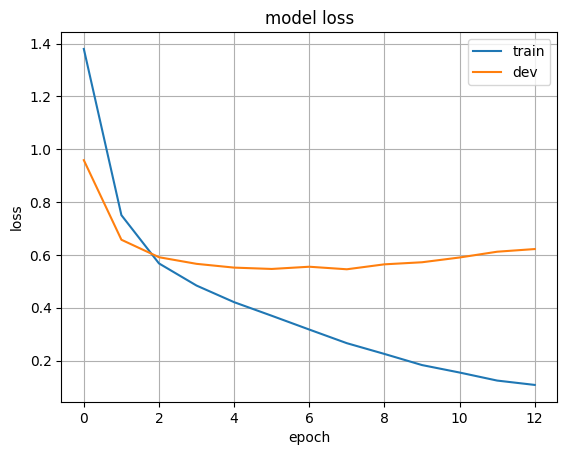

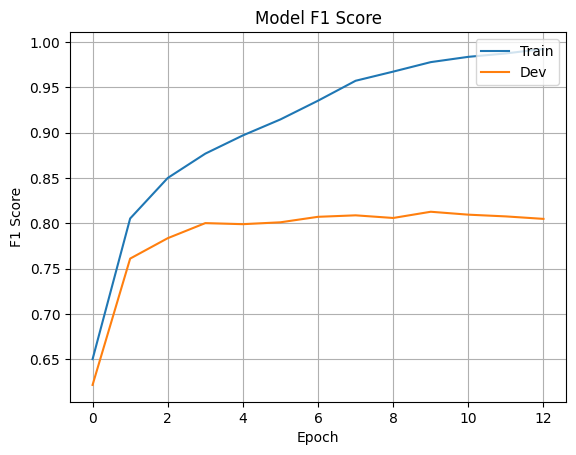

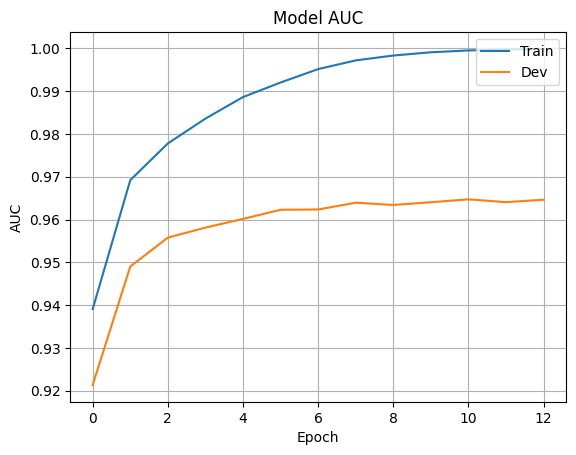

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.grid()
plt.show()

# summarize history for F1 score
plt.plot(history.history['train_f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.grid()
plt.show()

## **Evaluate BiDirectional GRU Model's Performance**

In [ ]:
from sklearn.metrics import classification_report

predictions = np.argmax(model.predict(val_data), -1)
print(classification_report(y_val, predictions,
                            target_names=label_names))

63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

     sadness       0.88      0.89      0.88       550
         joy       0.84      0.95      0.89       704
        love       0.88      0.68      0.77       178
       anger       0.87      0.85      0.86       275
        fear       0.93      0.73      0.81       212
    surprise       0.82      0.79      0.81        81

    accuracy                           0.86      2000
   macro avg       0.87      0.81      0.84      2000
weighted avg       0.87      0.86      0.86      2000



63/63 [==============================] - 1s 20ms/step
Classification Report for validation data:
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       550
           1       0.84      0.95      0.89       704
           2       0.88      0.68      0.77       178
           3       0.87      0.85      0.86       275
           4       0.93      0.73      0.81       212
           5       0.82      0.79      0.81        81

    accuracy                           0.86      2000
   macro avg       0.87      0.81      0.84      2000
weighted avg       0.87      0.86      0.86      2000



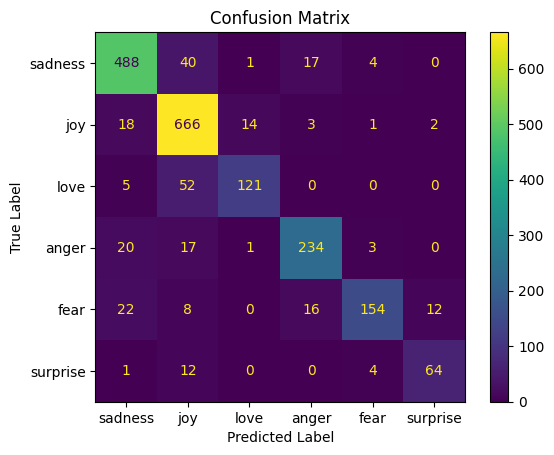

In [ ]:
distinct_train_labels_list=list(distinct_train_labels)
distinct_train_labels_string=[str(x) for x in distinct_train_labels_list]

# Load the saved weights into the model
#model.load_weights('checkpoints/tfidf_mlp.weights.h5')


# Generate predictions on the validation set
predictions = np.argmax(model.predict(val_data), -1)

# Convert numerical labels to their corresponding class names
predictions_classes = [distinct_train_labels_string[pred] for pred in predictions]
y_val_classes = [distinct_train_labels_string[label] for label in y_val]

# Print classification report for validation set
print("Classification Report for validation data:")
print(classification_report(y_val_classes, predictions_classes))

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, predictions)

# Plotting the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_names)
disp.plot(values_format=".0f")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **BiLSTM + Linear self attention**
This code defines and trains a neural network model for text classification using TensorFlow. The model architecture includes an embedding layer, a bidirectional LSTM layer, a custom self-attention layer, and dense layers with dropout for regularization. The training process incorporates custom metrics for evaluation and early stopping to halt training when the validation performance ceases to improve.

- This custom callback computes F1-score, recall, and precision at the end of each epoch on the validation data.
- Predictions are made on the validation data, and the true labels are compared to compute the metrics.
- This class defines a custom self-attention layer.
- The attention mechanism is implemented using an MLP.
- The layer computes attention weights and applies them to the input, summing over the sequence length.

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Layer

class SelfAttention(Layer):
  def __init__(self, mlp_layers=0, units=0, dropout_rate=0, return_attention=False, **kwargs):
    super(SelfAttention, self).__init__(**kwargs)
    self.mlp_layers = mlp_layers
    self.mlp_units = units
    self.return_attention = return_attention
    self.dropout_rate = dropout_rate
    self.attention_mlp = self.build_mlp()

  def build_mlp(self):
    mlp = Sequential()
    for i in range(self.mlp_layers):
      mlp.add(Dense(self.mlp_units, activation='relu'))
      mlp.add(Dropout(self.dropout_rate))
    mlp.add(Dense(1))
    return mlp

  def call(self, x, mask=None):
    # x  = [batch_size,max_len,H_rnn] ==> [batch_size*max_len,H_rnn]
    # a = [batch_size*max_len,H_rnn] * [H_rnn,1] = [batch_size*max_len,1]
    # a reshaped to 3D given batch_size and max_len values
    # a = [batch_size,max_len,1]
    a = self.attention_mlp(x)
    # squeze last dimension of a to get the final attention matrix [batch_size,max_len]
    a = tf.squeeze(a, axis=2)

    if mask is not None:
      # apply mask to zero out padded elements. Remember that exp ^ (large negative value) =  0
      mask = tf.keras.backend.cast(mask, tf.keras.backend.floatx())
      a -= 100000.0 * (1.0 - mask)

    # Aplply softmax to the max_len dimension
    a = tf.keras.backend.expand_dims(tf.keras.backend.softmax(a, axis=-1))
    # Element-wise multiplication of attention scores a [batch_size,max_len] with the original x matrix [batch_size,max_len,H_rnn]
    weighted_input = x * a  # [batch_size,max_len,H_rnn]
    # Add/sum scaled H_rnn dim over max_len dimension
    result = tf.keras.backend.sum(weighted_input, axis=1) # [batch_size, H_rnn]

    if self.return_attention:
      return [result, a]
    return result

- A sequential model is defined.
- An embedding layer is used to convert words to dense vectors.
- A bidirectional LSTM layer processes the sequence data.
- A custom self-attention layer is added.
- Dense layers with dropout are used for classification.
- The model is compiled with the Adam optimizer and categorical cross-entropy loss.
- Early stopping is configured to stop training if validation loss does not improve for 5 consecutive epochs.

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

LSTM_SIZE = 300
DENSE = 1000

# create empty sequential model
model2 = Sequential()
model2.add(Input(shape=(1,), dtype=tf.string))
model2.add(vectorizer)
# add an embedding layer
model2.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                    input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

# Use 0.33 dropout probabillity
model2.add(Dropout(0.33))
# add a bidirectional lstm layer with 0.33 variational (recurrent) dropout
model2.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout = 0.33)))
model2.add(Dropout(0.33))
# Add linear self-attention layer
# mlp_layers=0 ==>  # sum(softmax(WX + b) * X)
model2.add(SelfAttention(mlp_layers=0))


# add an MLP with 1 hidden layer
model2.add(Dense(units=DENSE, activation='relu' ))
model2.add(Dropout(0.33))
model2.add(Dense(len(label_names), activation='softmax'))
print(model2.summary())

model2.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=0.001),metrics=["categorical_accuracy"])

train_data = np.array([[" ".join(x_train)] for x_train in X_train_tokenized])
val_data = np.array([[" ".join(x_val)] for x_val in X_val_tokenized])

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # or 'val_categorical_accuracy' based on your needs
                               patience=5,  # Number of epochs with no improvement after which training will be stopped
                               restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
                               verbose=1)

history2 = model2.fit(train_data, y_train_1_hot,
              validation_data=(val_data, y_val_1_hot),
              batch_size=256,
              epochs=40,
              shuffle=True,
              callbacks=[Metrics(valid_data=(val_data, y_val_1_hot)), early_stopping])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_1 (Embedding)     (None, 30, 300)           30000000  
                                                                 
 dropout_5 (Dropout)         (None, 30, 300)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 600)           1442400   
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 30, 600)           0         
                                                                 
 self_attention (SelfAttent  (None, 600)              

/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 41s 614ms/step - loss: 1.5153 - categorical_accuracy: 0.4024 - val_loss: 1.3974 - val_categorical_accuracy: 0.4795 - val_f1: 0.3814 - val_recall: 0.4795 - val_precision: 0.3670
Epoch 2/40
63/63 [==============================] - 3s 46ms/step
 — val_f1: 0.535110 — val_precision: 0.608014 — val_recall: 0.584000
63/63 [==============================] - 41s 657ms/step - loss: 1.3065 - categorical_accuracy: 0.5036 - val_loss: 1.1378 - val_categorical_accuracy: 0.5840 - val_f1: 0.5351 - val_recall: 0.5840 - val_precision: 0.6080
Epoch 3/40


/home/gtriant/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


63/63 [==============================] - 3s 42ms/step
 — val_f1: 0.701404 — val_precision: 0.731370 — val_recall: 0.725500
63/63 [==============================] - 38s 609ms/step - loss: 1.0321 - categorical_accuracy: 0.6269 - val_loss: 0.8144 - val_categorical_accuracy: 0.7255 - val_f1: 0.7014 - val_recall: 0.7255 - val_precision: 0.7314
Epoch 4/40
63/63 [==============================] - 3s 41ms/step
 — val_f1: 0.783089 — val_precision: 0.792491 — val_recall: 0.792000
63/63 [==============================] - 38s 602ms/step - loss: 0.7826 - categorical_accuracy: 0.7243 - val_loss: 0.5934 - val_categorical_accuracy: 0.7920 - val_f1: 0.7831 - val_recall: 0.7920 - val_precision: 0.7925
Epoch 5/40
63/63 [==============================] - 3s 44ms/step
 — val_f1: 0.812283 — val_precision: 0.830388 — val_recall: 0.822500
63/63 [==============================] - 38s 599ms/step - loss: 0.6229 - categorical_accuracy: 0.7797 - val_loss: 0.4962 - val_categorical_accuracy: 0.8225 - val_f1: 0.8123 

**Summary**

The code sets up a text classification model using TensorFlow and includes custom metrics for evaluation and early stopping to enhance the training process. The model architecture leverages embedding and bidirectional LSTM layers, followed by a custom self-attention layer and dense layers for classification, and applies dropout for regularization.

## **Visualize BiLSTM Model's Training History**

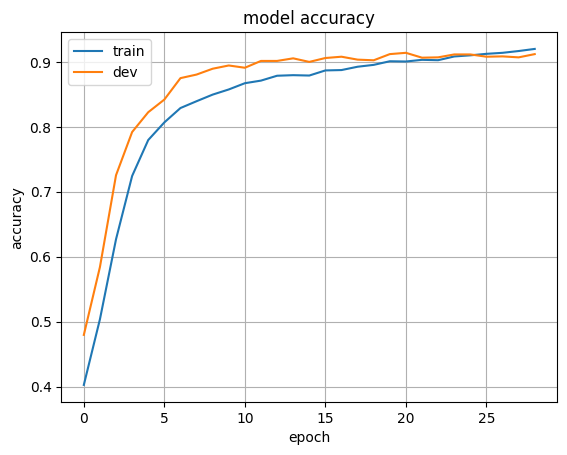

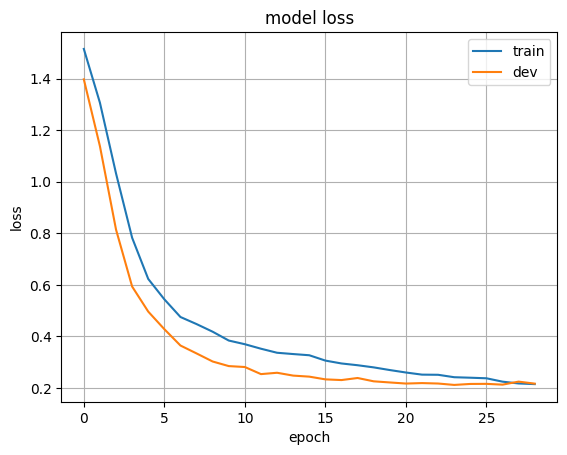

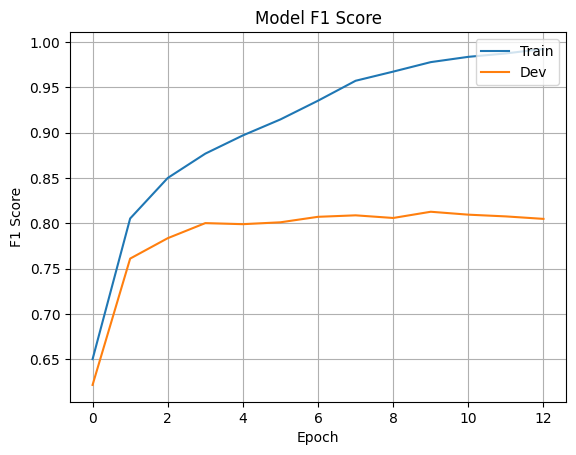

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.grid()
plt.show()

# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper right')
plt.grid()
plt.show()

# summarize history for F1 score
plt.plot(history.history['train_f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.grid()
plt.show()



## Evaluate BiLSTM + Linear self-attention on validation dataset

In [ ]:
predictions = np.argmax(model2.predict(val_data), -1)
print(classification_report(y_val, predictions, target_names=label_names))


63/63 [==============================] - 2s 34ms/step
              precision    recall  f1-score   support

     sadness       0.93      0.94      0.93       550
         joy       0.92      0.94      0.93       704
        love       0.87      0.83      0.85       178
       anger       0.91      0.93      0.92       275
        fear       0.87      0.85      0.86       212
    surprise       0.91      0.73      0.81        81

    accuracy                           0.91      2000
   macro avg       0.90      0.87      0.88      2000
weighted avg       0.91      0.91      0.91      2000



## Evaluate BiLSTM + Linear self-attention on Test Dataset

In [ ]:
test_data = np.array([[" ".join(x_test)] for x_test in X_test_tokenized])

# Classification report
predictions = np.argmax(model.predict(test_data), axis=-1)
print(classification_report(y_test, predictions, target_names=label_names))

63/63 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

     sadness       0.89      0.89      0.89       581
         joy       0.84      0.95      0.89       695
        love       0.81      0.60      0.69       159
       anger       0.87      0.85      0.86       275
        fear       0.94      0.74      0.83       224
    surprise       0.67      0.73      0.70        66

    accuracy                           0.86      2000
   macro avg       0.84      0.79      0.81      2000
weighted avg       0.86      0.86      0.86      2000



* MAX_WORDS is the Vocabulary size, which is 5000. It is the max size of words that the TextVectorization() will keep track on
* MAX_SEQUENCE_LENGTH is the fixed size of the sentence that our RNN will read. We use 19 since this is the average sentence length
* EMBEDDING_DIM it is not directly used in TextVectorization() but will be used later when creating an embedding layer for the model.**The embedding dimension determines the size of the vectors in which words will be represented.**

## HYPERPARAMETER TUNING - DEV

Synopsis
The provided code performs hyperparameter tuning for a text classification model using a random search strategy. The model incorporates an embedding layer, bidirectional LSTM layers, a custom self-attention mechanism, and dense layers. The model training process includes early stopping to prevent overfitting by halting training when the validation loss ceases to improve.

- random is used for selecting hyperparameters randomly.
- TensorFlow is used for building and training the neural network.
- Sequential model type from TensorFlow is used to stack layers sequentially.
- Various layers are imported for constructing the neural network.
- Adam optimizer from TensorFlow's legacy module is used due to performance issues with the newer version on certain hardware.
- classification_report from sklearn.metrics is used for evaluation.
- NumPy is used for numerical operations.
- EarlyStopping from TensorFlow's callbacks is used to halt training early when validation performance stops improving.
- The dictionary "hyperparameters" defines the search space for hyperparameters, specifying possible values for the number of LSTM layers, MLP layers, units in MLP layers, and learning rates.

In [ ]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define the hyperparameter search space
hyperparameters = {
    'lstm_layers': [1, 2],
    'mlp_layers': [ 1, 2],
    'mlp_units': [16, 256, 512],
    'learning_rate': [1e-5, 1e-3]
}

def create_model(params):
    lstm_layers = params['lstm_layers']
    mlp_layers = params['mlp_layers']
    mlp_units = params['mlp_units']
    learning_rate = params['learning_rate']

    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorizer)
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

    for _ in range(lstm_layers):
        model.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33)))
        model.add(Dropout(0.33))

    model.add(SelfAttention(mlp_layers=mlp_layers, units=mlp_units))
    model.add(Dense(units=DENSE, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(len(label_names), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=["categorical_accuracy"])

    return model

- create_model function constructs the model based on provided hyperparameters.
- lstm_layers, mlp_layers, mlp_units, and learning_rate are dynamically set according to the values passed in params.
- The model consists of:
    - An input layer.
    - A vectorizer layer for converting input text into sequences.
    - An embedding layer initialized with pre-trained weights.
    - One or two Bidirectional LSTM layers with dropout for regularization.
    - A custom SelfAttention layer for computing attention scores.
    - Dense layers with ReLU activation and dropout.
    - An output layer with softmax activation for classification.
- The model is compiled with categorical cross-entropy loss and Adam optimizer.
- An EarlyStopping callback is defined to monitor the validation loss and stop training if it doesn't improve for five epochs.

In [ ]:
# With early stopping
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Embedding, Bidirectional, LSTM
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam

from sklearn.metrics import classification_report
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Define the hyperparameter search space
hyperparameters = {
    'lstm_layers': [1, 2],
    'mlp_layers': [1, 2],
    'mlp_units': [256, 512],
    'learning_rate': [1e-5, 1e-3]
}

def create_model(params):
    lstm_layers = params['lstm_layers']
    mlp_layers = params['mlp_layers']
    mlp_units = params['mlp_units']
    learning_rate = params['learning_rate']

    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorizer)
    model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, weights=[embedding_matrix],
                        input_length=MAX_SEQUENCE_LENGTH, mask_zero=True, trainable=False))

    for _ in range(lstm_layers):
        model.add(Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, recurrent_dropout=0.33)))
        model.add(Dropout(0.33))

    model.add(SelfAttention(mlp_layers=mlp_layers, units=mlp_units))
    model.add(Dense(units=DENSE, activation='relu'))
    model.add(Dropout(0.33))
    model.add(Dense(len(label_names), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=["categorical_accuracy"])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    return model, early_stopping


- This section performs hyperparameter tuning using a random search strategy.
- best_val_accuracy and best_params variables are initialized to track the best validation accuracy and corresponding hyperparameters.
- A loop runs for a fixed number of trials (5 in this case), selecting random values for hyperparameters from the predefined search space.
- For each trial:
    - create_model is called with the selected hyperparameters to build and compile the model.
    - The model is trained using the fit method with the training and validation data. Early stopping is applied via the callback.
    - The highest validation accuracy from the training history is retrieved.
    - If the current model's validation accuracy surpasses the previous best, the accuracy and hyperparameters are updated.
- After all trials, the best hyperparameters and validation accuracy are printed.

In [ ]:
best_val_accuracy = 0
best_params = None

# Perform random search
for _ in range(5):  # Number of trials
    params = {
        'lstm_layers': random.choice(hyperparameters['lstm_layers']),
        'mlp_layers': random.choice(hyperparameters['mlp_layers']),
        'mlp_units': random.choice(hyperparameters['mlp_units']),
        'learning_rate': random.choice(hyperparameters['learning_rate'])
    }

    model, early_stopping = create_model(params)

    # Define early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=3,           # Number of epochs with no improvement after which training will be stopped
        restore_best_weights=True  # Restore model weights that give the best validation loss
    )

    history = model.fit(train_data, y_train_1_hot,
                        validation_data=(val_data, y_val_1_hot),
                        batch_size=256,
                        epochs=10,
                        shuffle=True,
                        callbacks=[early_stopping],  # Add early stopping callback
                        verbose=0)

    val_accuracy = max(history.history['val_categorical_accuracy'])

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params

print("Best hyperparameters: ", best_params)
print("Best validation accuracy: ", best_val_accuracy)



In [ ]:
best_params

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.show()

# summarize history for F1 score
plt.plot(history.history['train_f1'])
plt.plot(history.history['val_f1'])
plt.title('Model F1 Score')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Dev'], loc='upper right')
plt.grid()
plt.show()

# Classification report
predictions = np.argmax(model.predict(val_data), axis=-1)
print(classification_report(y_val, predictions, target_names=label_names))


## EVALUATE OPTIMISED MODEL ON TEST DATA


In [ ]:
# Classification report
predictions = np.argmax(model.predict(test_data), axis=-1)
print(classification_report(y_test, predictions, target_names=label_names))

In [ ]:
test_data = np.array([[" ".join(x_test)] for x_test in X_test_tokenized])
predictions = np.argmax(model.predict(test_data), axis=-1)
print(classification_report(y_test, predictions, target_names=label_names))


